# The Data Scientist's Guide to Movie Success

## Introduction
The North American movie industry generated USD 4.7 billion in 2020. As restrictions related to the COVID pandemic eases, the industry is expected to recover. As the movie industry regains its footing and welcomes production once again, this becomes an opportune moment for data scientists to jump in on the action. But what movie should we make, and how?

### Question and Goal
The question we wish to answer is: which factors have the most positive impact in achieving success? And what metric do we use to measure success?

### Dataset
The dataset we will be using is sourced from kaggle and contains metadata for 45,000 movies, which were released before July 2017. The variables of the dataset include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages. The dataset also has user ratings of these movies on a scale of 1-5 obtained from the official GroupLens website.

## Methods and Results

Below details our steps for the preprocessing, exploratory and analysis phases:

##### Preprocessing

1. Load packages
2. Load dataset from Kaggle using httr library
3. Transform quantitative columns
4. Summarize and filter out NA and 0 values

##### Exploratory Analysis and Further Wrangling
1. Explore budget and revenue
2. Explore vote count
3. Explore genre
4. Seperate the main training and test sets
5. Observe data pairs
6. Variable Selection

##### Data Analysis
1. Finding best knn
    - Generate recipe, knn spec, workflow, folds, list of k to tune with
    - Find the k with minimum rmse score using tune_grid() and cross-validation
    - Use the min k to fit model
    - Perform predictions with model and obtain rmspe
2. Plotting the model

#### Pre-Processing


##### Loading packages

In [1]:
library(tidyverse)
library(repr)
library(jsonlite)
library(purrr)
library(tidymodels)
library(gridExtra)
library(httr)
library(GGally)
library(dplyr)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘jsonlite’ was built under R version 4.0.2”

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0 

##### Reading data from Kaggle using the "httr" library

In [2]:
username <- "dinaramamatova"
key <- "e886333383b601f58ee65062844a991b"

temp <- tempfile(pattern = "", fileext = ".csv")

meta_kaggle    <- httr::GET("https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset/movies_metadata.csv",
                  httr::authenticate(username, key, type = "basic"))
# rating_kaggle  <- httr::GET("https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset/ratings_small.csv",
#                   httr::authenticate(username, key, type = "basic"))
# credits_kaggle <- httr::GET("https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset/credits.csv",
#                   httr::authenticate(username, key, type = "basic"))

# For Mac
download.file(meta_kaggle$url,    temp)
# download.file(rating_kaggle$url,  temp)
# download.file(credits_kaggle$url, temp)

# For Windows
download.file(meta_kaggle$url,    temp, mode = "wb")
# download.file(rating_kaggle$url,  temp, mode = "wb")
# download.file(credits_kaggle$url, temp, mode = "wb")

meta_data    <- read.csv(unz(temp, "movies_metadata.csv"))
# ratings_data <- read.csv(unz(temp, "ratings_small.csv"))
# credits_data <- read.csv(unz(temp, "credits.csv"))

unlink(temp)

glimpse(meta_data)

Rows: 45,466
Columns: 24
$ adult                 <chr> "False", "False", "False", "False", "False", "F…
$ belongs_to_collection <chr> "{'id': 10194, 'name': 'Toy Story Collection', …
$ budget                <chr> "30000000", "65000000", "0", "16000000", "0", "…
$ genres                <chr> "[{'id': 16, 'name': 'Animation'}, {'id': 35, '…
$ homepage              <chr> "http://toystory.disney.com/toy-story", "", "",…
$ id                    <chr> "862", "8844", "15602", "31357", "11862", "949"…
$ imdb_id               <chr> "tt0114709", "tt0113497", "tt0113228", "tt01148…
$ original_language     <chr> "en", "en", "en", "en", "en", "en", "en", "en",…
$ original_title        <chr> "Toy Story", "Jumanji", "Grumpier Old Men", "Wa…
$ overview              <chr> "Led by Woody, Andy's toys live happily in his …
$ popularity            <chr> "21.946943", "17.015539", "11.7129", "3.859495"…
$ poster_path           <chr> "/rhIRbceoE9lR4veEXuwCC2wARtG.jpg", "/vzmL6fP7a…
$ production_companies  <ch

At a glance, there are some challenges to tidying the data. One primary challenge is that some of the data like 'belongs_to_collection' is difficult to parse. The cells of the variable 'belong_to_collection' not only contain multiple observations, but is also framed by complicated json syntax.

Frankly, we haven't yet learned how to parse this sort of data effectively. The only thing we could do is create 'genre labels' later on that assign numbers to the primary genres (the first genre in the list) of each movie. We simply assumed this to be the most important genre but there are remaining questions regarding the credibility of how we assign things and the logical reasoning behind setting our own standards for these indicators. This ensured a smaller error in the final model created because the way we assign numbers to genres is essentially incorrect and doesn't have much impact on the amount of revenue (or 'success') of the film.

Furthermore, we decided to use less restrictive filtering and creating a model with less variables because introducing more would only lower the average revenue earned, making the error smaller.

##### Cleaning and wrangling our data

First let's transform quantitive columns, such as budget and popularity, to their numeric representation to be able to work on them easily:

In [4]:
meta_data <- meta_data %>%
    mutate(budget = as.numeric(budget)) %>%
    mutate(popularity = as.numeric(popularity))

Warning message:
“Problem with `mutate()` input `budget`.
ℹ NAs introduced by coercion
ℹ Input `budget` is `as.numeric(budget)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `popularity`.
ℹ NAs introduced by coercion
ℹ Input `popularity` is `as.numeric(popularity)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


Next we will explore NA and 0 values as they play a pertinent role in the summary function used later:

In [5]:
summary(meta_data)

    adult           belongs_to_collection     budget         
 Length:45466       Length:45466          Min.   :        0  
 Class :character   Class :character      1st Qu.:        0  
 Mode  :character   Mode  :character      Median :        0  
                                          Mean   :  4224579  
                                          3rd Qu.:        0  
                                          Max.   :380000000  
                                          NA's   :3          
    genres            homepage              id              imdb_id         
 Length:45466       Length:45466       Length:45466       Length:45466      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                          

After reading in the meta_data table for our future analysis, we can notice that in columns like revenue, budget, popularity, runtime, vote_average and vote_count, there are quiet a few NA values, as well as those values which equal to the minimum of 0. With the assumtion that these NA values and unrealistic 0-vaues represent missing information about the movies, we came to conclusion to remove all rows with missing info from our dataset, as they can incorrectly influence future prediction model and we already have lots of data to perform our analysis on:

In [6]:
meta_data <- meta_data %>% 
    drop_na() %>%
    filter(revenue > 0, budget > 0, runtime > 0, vote_average > 0, vote_count > 0, popularity > 0)

Now, let's go through some major variables of the dataframe to aquire the relationship between possible predictors and the outcome variable - revenue - for our analysis:

#### Exploratory Analysis and Further Wrangling


##### Budget vs Revenue

One of the first variables we will explore from the table is the budget variable, which, as told by Gunter (2018), is the key part during the earlier stages of movie production in assessment of future success of the movie. This is due to the fact that bigger budgets should reduce the probability of failure because it allows production companies to purchase better stories, cast, crew and facilities. We decided to plot a scatter graph to make sure that Gunter's claims remain true on our current dataset.

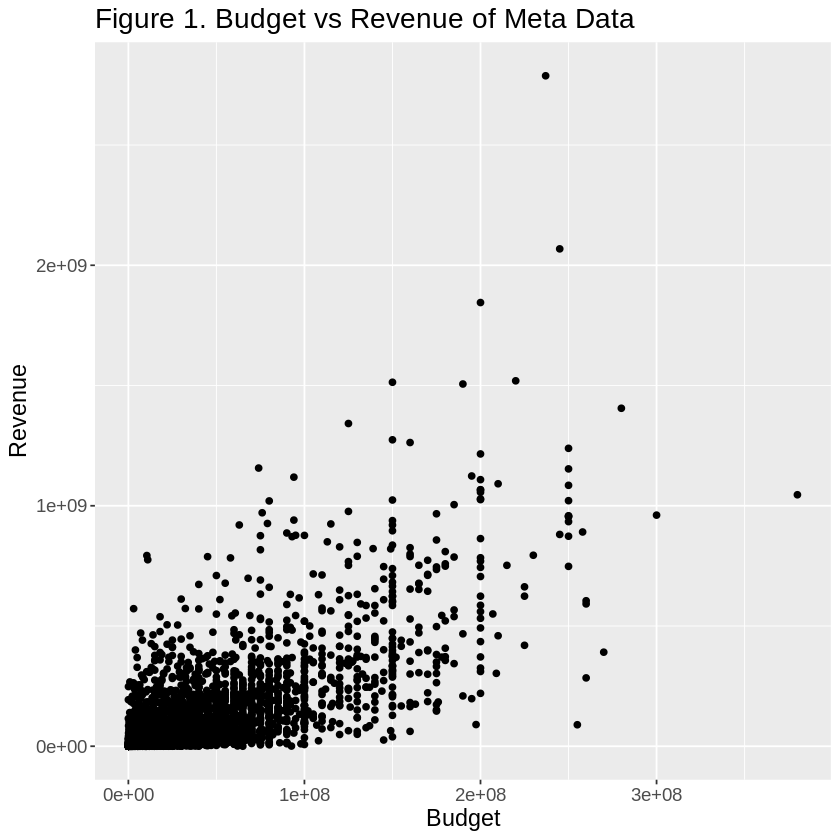

In [7]:
budget_revenue <- ggplot(meta_data, aes(x = budget, y = revenue)) +
    geom_point() +
    labs(x = "Budget", y = "Revenue")+
    ggtitle("Figure 1. Budget vs Revenue of Meta Data") +
    theme(text = element_text(size = 14))

budget_revenue

As we can see from the graph above, the budget of the movie has a clear positive correlation with its revenue: as the value of budget increases, the revenue increases as well. Thus, we should definitely include the budget variable as one of the predictor variables for our final models.

##### Importance of Vote Count

According to Carrillat, Legoux and Hadida (2017), the volume (or the number) of user reviews tend to sway our decisions on whether to watch the movie in cinema, or not, to a significant extent, even more than the their cummulative valence. Therefore, movies with a bigger number of user review votes(vote_count in the dataset) should give us more accurate predictions and estimates of the box office revenue, than if we were just building a model on a full set of movies, including those with an inconclusive number of movie reviews. We decided to partition the movies into two sets - movies with big vote_count (> 500) and movies with small vote_count (<= 500) - and compare the scatter plots based on these sets to better gauge the relationship between the number of votes to the movie by users and its revenue revenue.

Warning message:
“Removed 8 rows containing missing values (geom_point).”


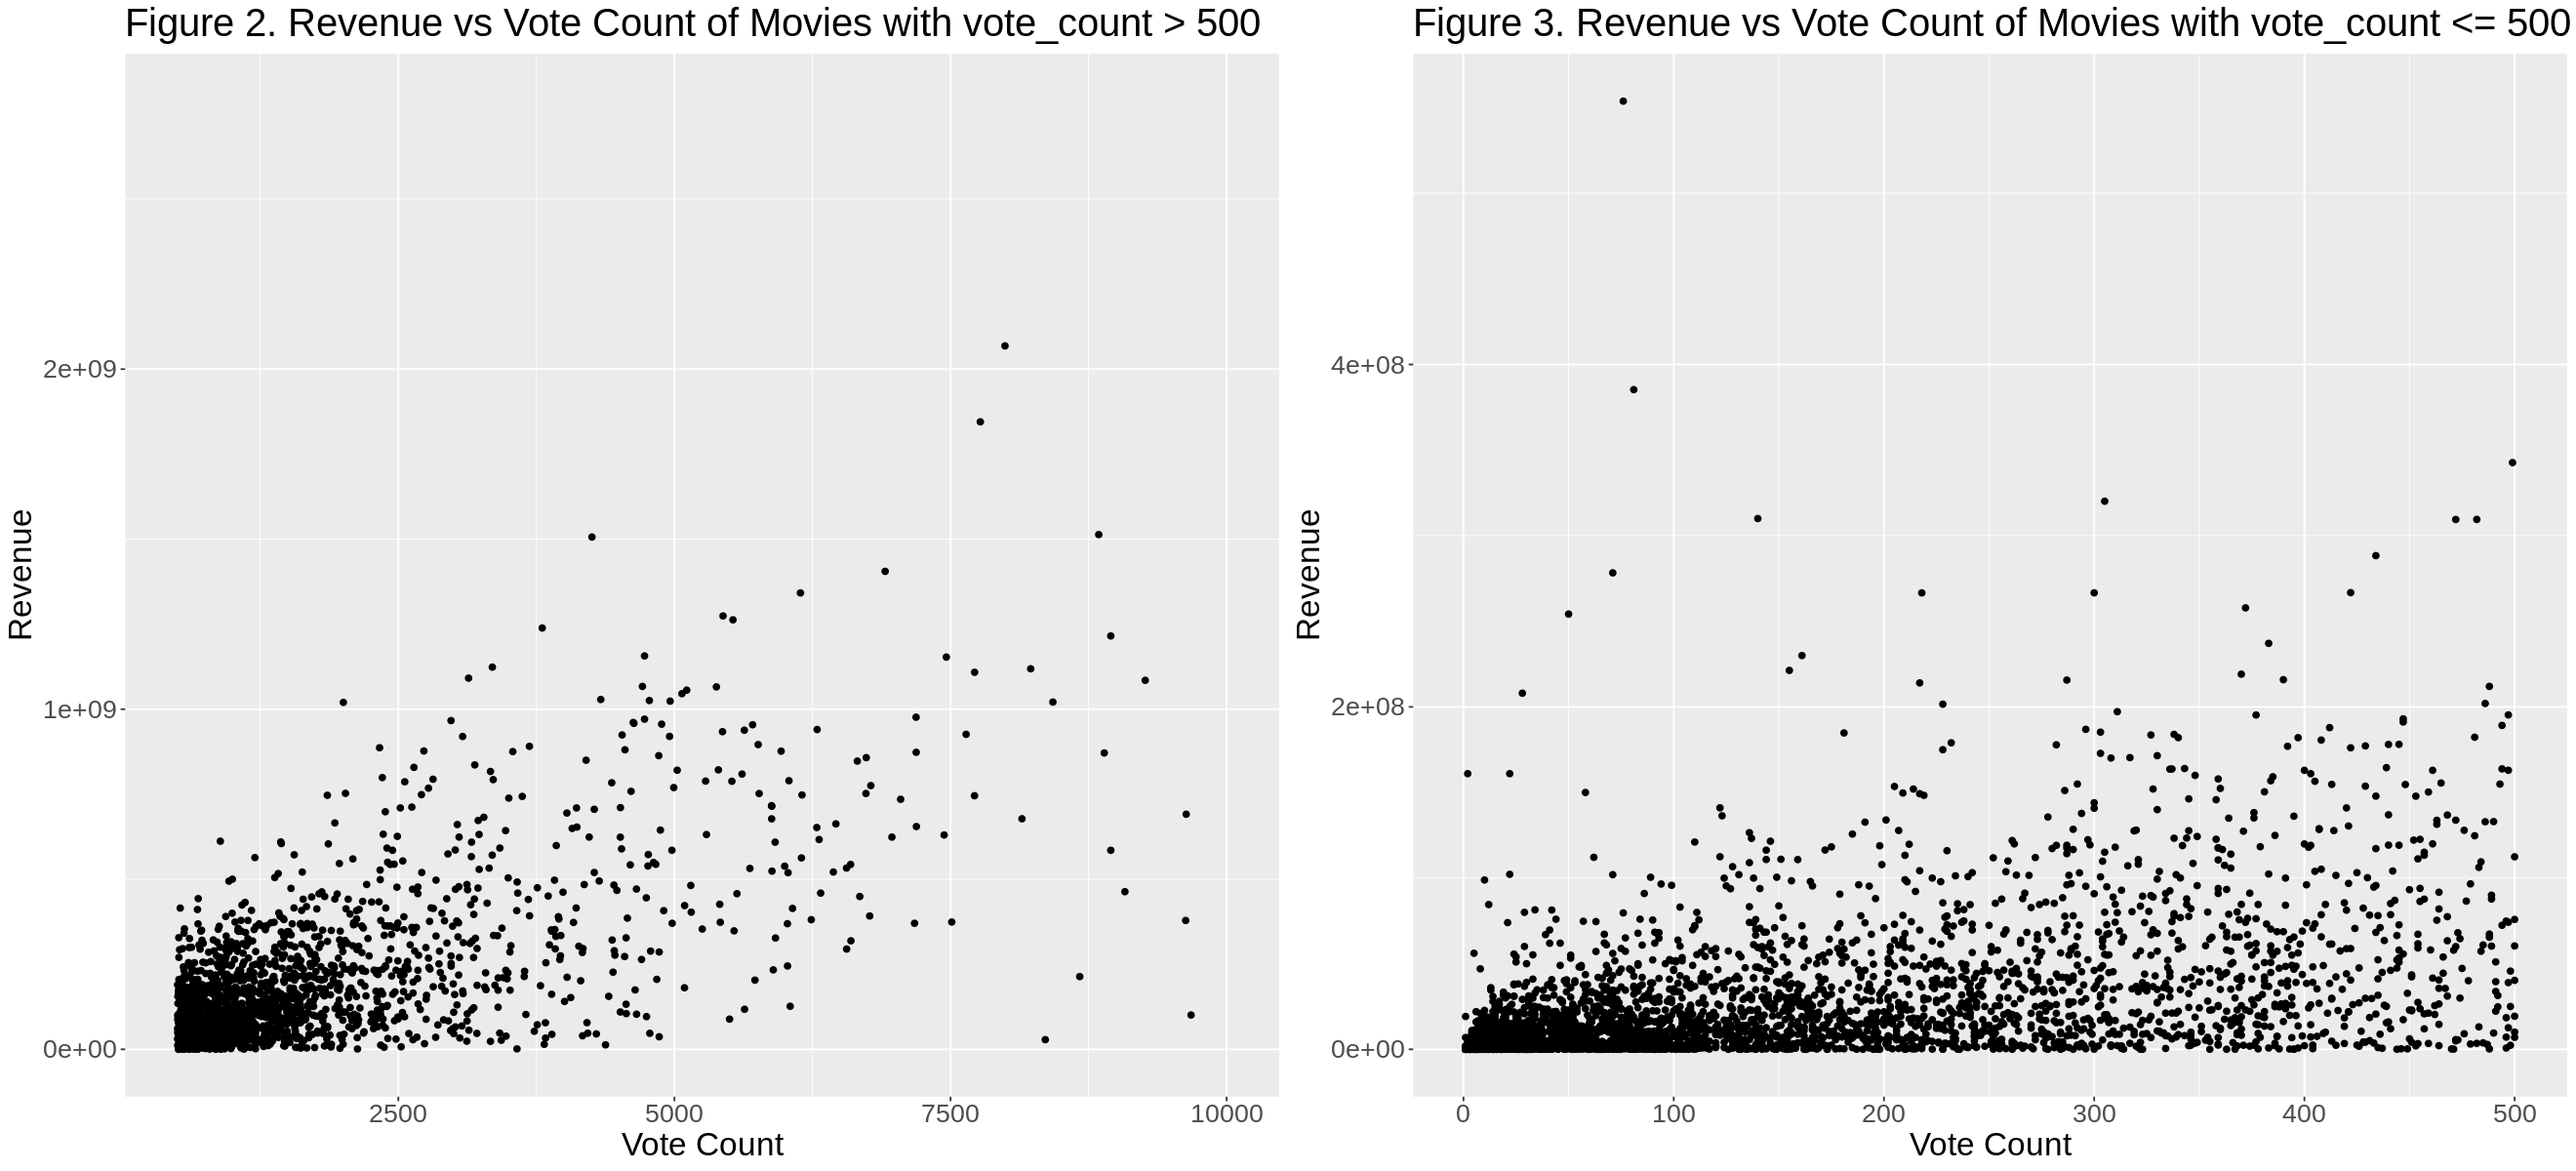

In [8]:
big_vote_count <- filter(meta_data, vote_count > 500)
small_vote_count <- filter(meta_data, vote_count <= 500)

big_vote_plot <- ggplot(big_vote_count, aes(x = vote_count, revenue)) +
    geom_point() +
    labs(x = "Vote Count", y = "Revenue") +
    xlim(c(501, 10000)) +
    theme(text = element_text(size = 20))+
    ggtitle("Figure 2. Revenue vs Vote Count of Movies with vote_count > 500")

small_vote_plot <- ggplot(small_vote_count, aes(x = vote_count, revenue)) +
    geom_point() +
    labs(x = "Vote Count", y = "Revenue") +
    theme(text = element_text(size = 20))+
    ggtitle("Figure 3. Revenue vs Vote Count of Movies with vote_count <= 500")

options(repr.plot.width = 22, repr.plot.height = 10)

plot_grid(big_vote_plot, small_vote_plot, ncol = 2)

Indeed, based on two plots, we can say that the movies with bigger number of user reviews tend to have a strong correlation between the # of votes and revenue, while the movies with smaller number of user reviews do not have this correlation, or exhibit it too weak. We figured that such a difference between vote_count and revenue relationship in two graphs is caused by the fact that movies with smaller user counts have smaller audiences that may be able to influence the opinions of others. Therefore, for our analysis and future prediction model, solving the regression problem, that works better on datasets with relationship between predictors and outcome, we will choose to predict only on movies with vote counts over 500.

In [9]:
movies <- meta_data %>% filter(vote_count > 500)

##### Genre Parsing and Exploration

Let's assume that the first genre in the list of genres for the movie is the the movie's main genre. So, we extract the first genre from the genres column and match it with appropriate numerical label as a new variable F:


In [10]:
movies <- movies %>% 
    separate(genres, sep = "['']" ,  c("A","B","C","D","E","F")) %>%
    filter(!is.na(F)) %>%
    mutate(Genre_label = case_when( 
        F == "Action" ~ 1,
        F == "Adventure" ~ 2,
        F == "Animation" ~ 3,
        F == "Comedy" ~ 4,
        F == "Crime" ~ 5,
        F == "Documentary" ~ 6,
        F == "Drama" ~ 7,
        F == "Family" ~ 8,
        F == "Fantasy" ~ 9,
        F == "Foreign" ~ 10,
        F == "History" ~ 11,
        F == "Horror" ~ 12,
        F == "Music" ~ 13,
        F == "Mystery" ~ 14,
        F == "Romance" ~ 15,
        F == "Science Fiction" ~ 16,
        F == "Thriller" ~ 17,
        F == "TV Movie" ~ 18,
        F == "War" ~ 19,
        F == "Western" ~ 20)) %>%
    relocate(Genre_label, .before = F)

Warning message:
“Expected 6 pieces. Additional pieces discarded in 1913 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


Now let's see if different genres lead to significantly different revenues by plotting a bar chart:

`summarise()` ungrouping output (override with `.groups` argument)



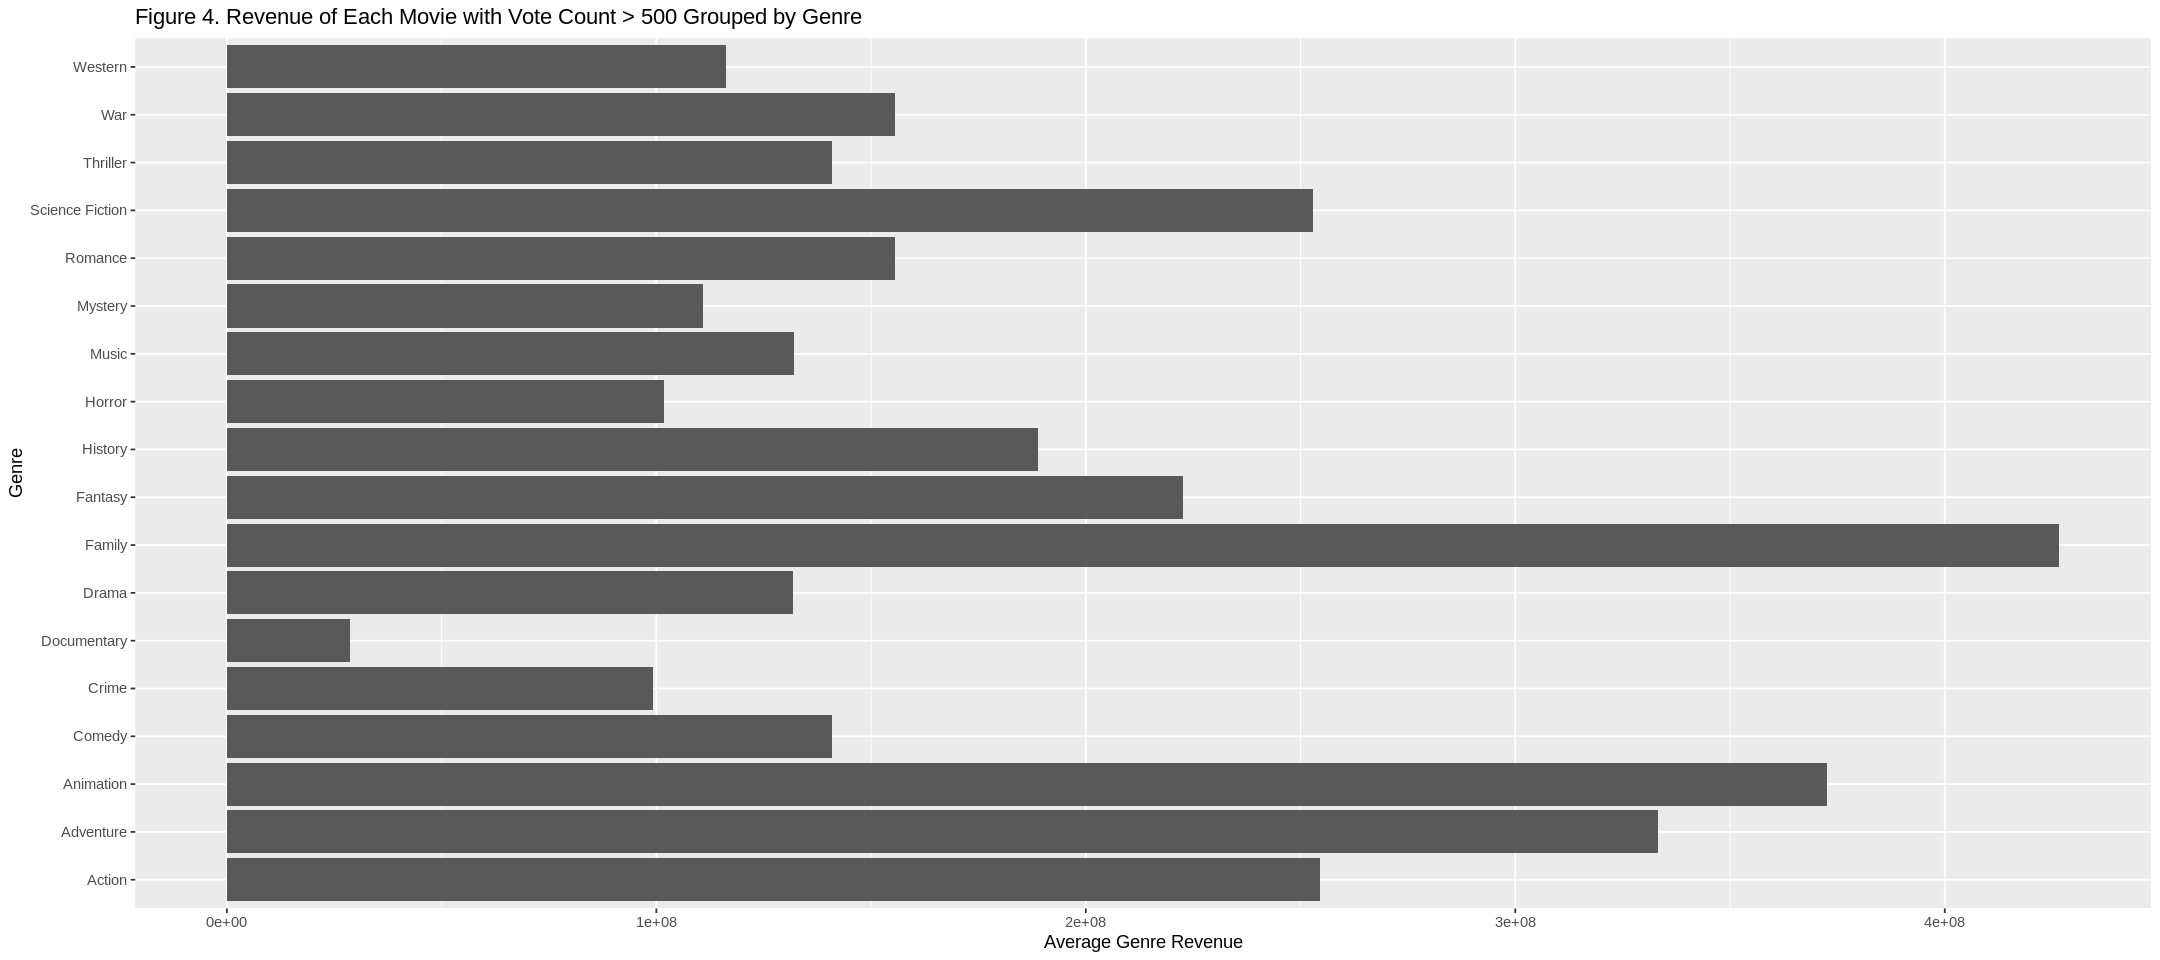

In [11]:
genres_df <- select(movies, F, revenue)  %>%
    group_by(F) %>%
    summarize(Genre_mean_revenue = mean(revenue, na.rm = TRUE))

genres_bar <- ggplot(genres_df, aes(x = Genre_mean_revenue, y = F)) +
        geom_col() +
        labs(x = "Average Genre Revenue", y = "Genre")+
        ggtitle("Figure 4. Revenue of Each Movie with Vote Count > 500 Grouped by Genre")

options(repr.plot.width = 18, repr.plot.height = 8)
genres_bar

From the graph above we can see that different genres do lead to different box office revenues, thus we need to take genres into consideration when building our linear regression model. However, we also need to keep in mind that some of these observations of median values for genres may not be accurate due to over/under-sampling of the movies of some genres.

In [12]:
movies <- movies %>% 
    select("id","title", "runtime","budget","revenue","popularity","vote_average","vote_count","F", "Genre_label","release_date")

##### Summary of Wrangled Dataset

In [13]:
summary(movies)

      id               title              runtime        budget        
 Length:1913        Length:1913        Min.   : 64   Min.   :1.00e+00  
 Class :character   Class :character   1st Qu.: 98   1st Qu.:1.70e+07  
 Mode  :character   Mode  :character   Median :110   Median :4.00e+07  
                                       Mean   :113   Mean   :5.58e+07  
                                       3rd Qu.:124   3rd Qu.:7.80e+07  
                                       Max.   :238   Max.   :3.80e+08  
    revenue            popularity        vote_average     vote_count   
 Min.   :4.600e+01   Min.   :  0.3939   Min.   :4.000   Min.   :  501  
 1st Qu.:5.603e+07   1st Qu.:  9.4037   1st Qu.:6.100   1st Qu.:  735  
 Median :1.262e+08   Median : 11.8988   Median :6.600   Median : 1158  
 Mean   :2.028e+08   Mean   : 15.2714   Mean   :6.618   Mean   : 1772  
 3rd Qu.:2.547e+08   3rd Qu.: 15.4508   3rd Qu.:7.200   3rd Qu.: 2109  
 Max.   :2.788e+09   Max.   :547.4883   Max.   :9.100   Max.   :

#### Split dataset

In [14]:
set.seed(1)

movies_split <- initial_split(movies, prop = 0.75, strata = revenue)
movies_train <- training(movies_split)
movies_test  <- testing(movies_split)

#### Explore variable relationships

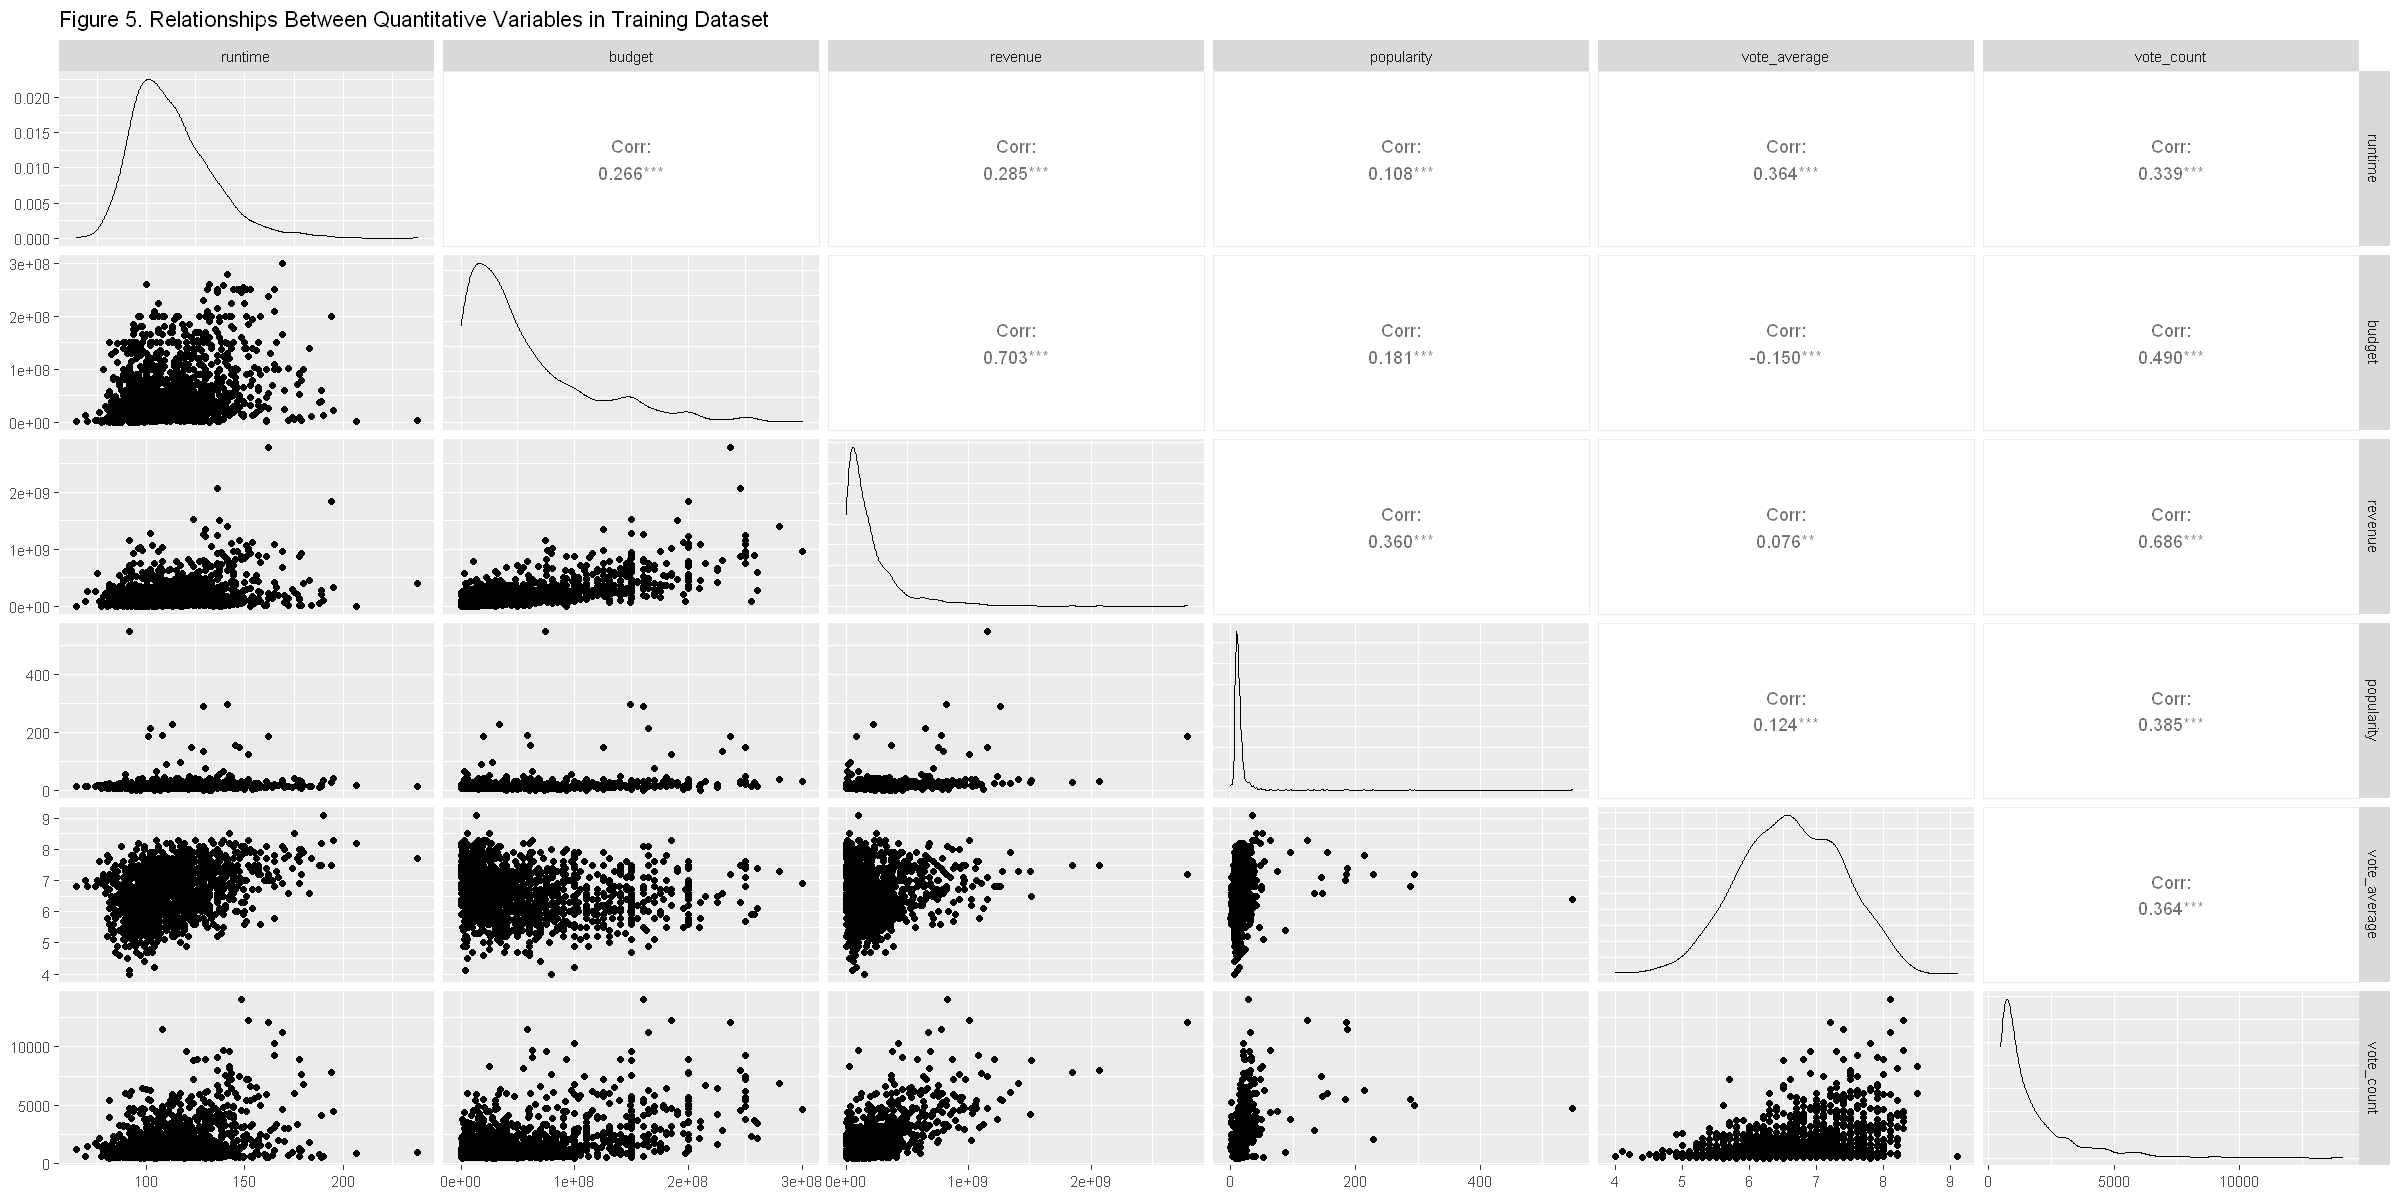

In [14]:
data_pairs <- ggpairs(movies_train, columns = 3:8) + 
              ggtitle("Figure 5. Relationships Between Quantitative Variables in Training Dataset")
options(repr.plot.width = 20, repr.plot.height = 10)
data_pairs 

#### Variable Selection ####

Our team used the Foward Selection method in order to choose the best combination of predictor variables. This is because we have a large amount data points and a small amount of potential predictor variables. The structure of our dataset will keep the risk of finding a model with high validation accuracy but low test accuracy. We selected by selecting variables that would intuitively have seem to have a impact on profitability. Variable such as average of user's raitings, budget of the movie and how many votes were recorded by movieLens critics.

In [16]:
# select all predictors
movies_selection <- movies_train %>%
    select(runtime,budget,revenue,vote_average,vote_count,Genre_label)
# select all predictor column names
movies_names <- colnames(movies_selection %>% select(-revenue))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Regression model
movies_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
         set_engine("kknn") %>%
         set_mode("regression")

# Cross-validation folds
movies_vfold <- vfold_cv(movies_train, v = 5, strata = revenue)

# Store number of predictors
n_total <- length(movies_names)

# Stores selected predictors
selected <- c()

# double for loop to test every iteration
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(movies_names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, movies_names[[j]])
        model_string <- paste("revenue", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
         selection_recipe <- recipe(as.formula(model_string), 
                                data = movies_selection) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(selection_recipe) %>%
          add_model(movies_spec) %>%
          tune_grid(resamples = movies_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "rmse") %>%
          summarize(mx = min(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.min(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, movies_names[[jstar]])
    names <- movies_names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,revenue ~ vote_count,175412152
2,revenue ~ vote_count+budget,144710046
3,revenue ~ vote_count+budget+Genre_label,142571639
4,revenue ~ vote_count+budget+Genre_label+runtime,140812196
5,revenue ~ vote_count+budget+Genre_label+runtime+vote_average,139269115


##### Predictors
After running a forward selection algorithm we found that a combination of vote_count, budget, runtime and popularity score gave the highest accuracy.
We have provided a quick explanation of each of the variables that we will be using in our classifier:
* Budget is the given budget allocated to the production of the movie.
* Vote_count is the number of reviewers that voted on the movies_lens website.
* Vote_average is the average vote raiting of the movie made by users on the movie_lens website.
* Popularity is a unique score calculated by the movies database team using variables such as number of votes per day and number of user who "favourite" the movie. - idk
* Runtime is the duration of the movie.

#### Data Analysis

In [18]:
# Find best knn and RMSPE
set.seed(1)

# Generate recipe. Based on forward selection, the predictors are: 
# vote_count, budget, runtime, popularity
movies_recipe <- recipe(revenue ~ vote_count + budget + runtime + vote_average, data = movies_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

# Generate knn_spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>%
    set_mode("regression") 

# Generate workflow
movies_workflow <- workflow() %>%
    add_recipe(movies_recipe) %>%
    add_model(knn_spec)

# Generate folds
vfold <- vfold_cv(movies_train, v = 5, strata = revenue)

# Generate list of k to tune with
gridvals <- tibble(neighbors = seq(from=1, to=20))

# Get K with best rmse score
rmse_table <- movies_workflow %>%
    tune_grid(resamples = vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "rmse") %>%
    filter(mean == min(mean))
rmse_table
rmse <- rmse_table %>% pull(mean)
k_min <- rmse_table %>% pull(neighbors)
sprintf("Minimum k is: %.0f with an rmse of %.0f",k_min, rmse)

# Use that k to fit the best model
movies_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
    set_engine("kknn") %>%
    set_mode("regression")
movies_best_fit <- workflow() %>%
        add_recipe(movies_recipe) %>%
        add_model(movies_best_spec) %>%
        fit(data = movies_train)

# Use the best model to generate predictions
movie_preds <- movies_best_fit %>%
    predict(movies_test) %>%
    bind_cols(movies_test) 


# Get rmspe of the best model
knn_rmspe <- movie_preds %>%
    metrics (truth = revenue, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    select(.estimate) %>%
    pull()

sprintf("rmspe is: %.0f", knn_rmspe)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,rmse,standard,141549680,5,11906262,Model10


[1] "Minimum k is: 10 with an rmse of 141549680"

[1] "rmspe is: 129725650"

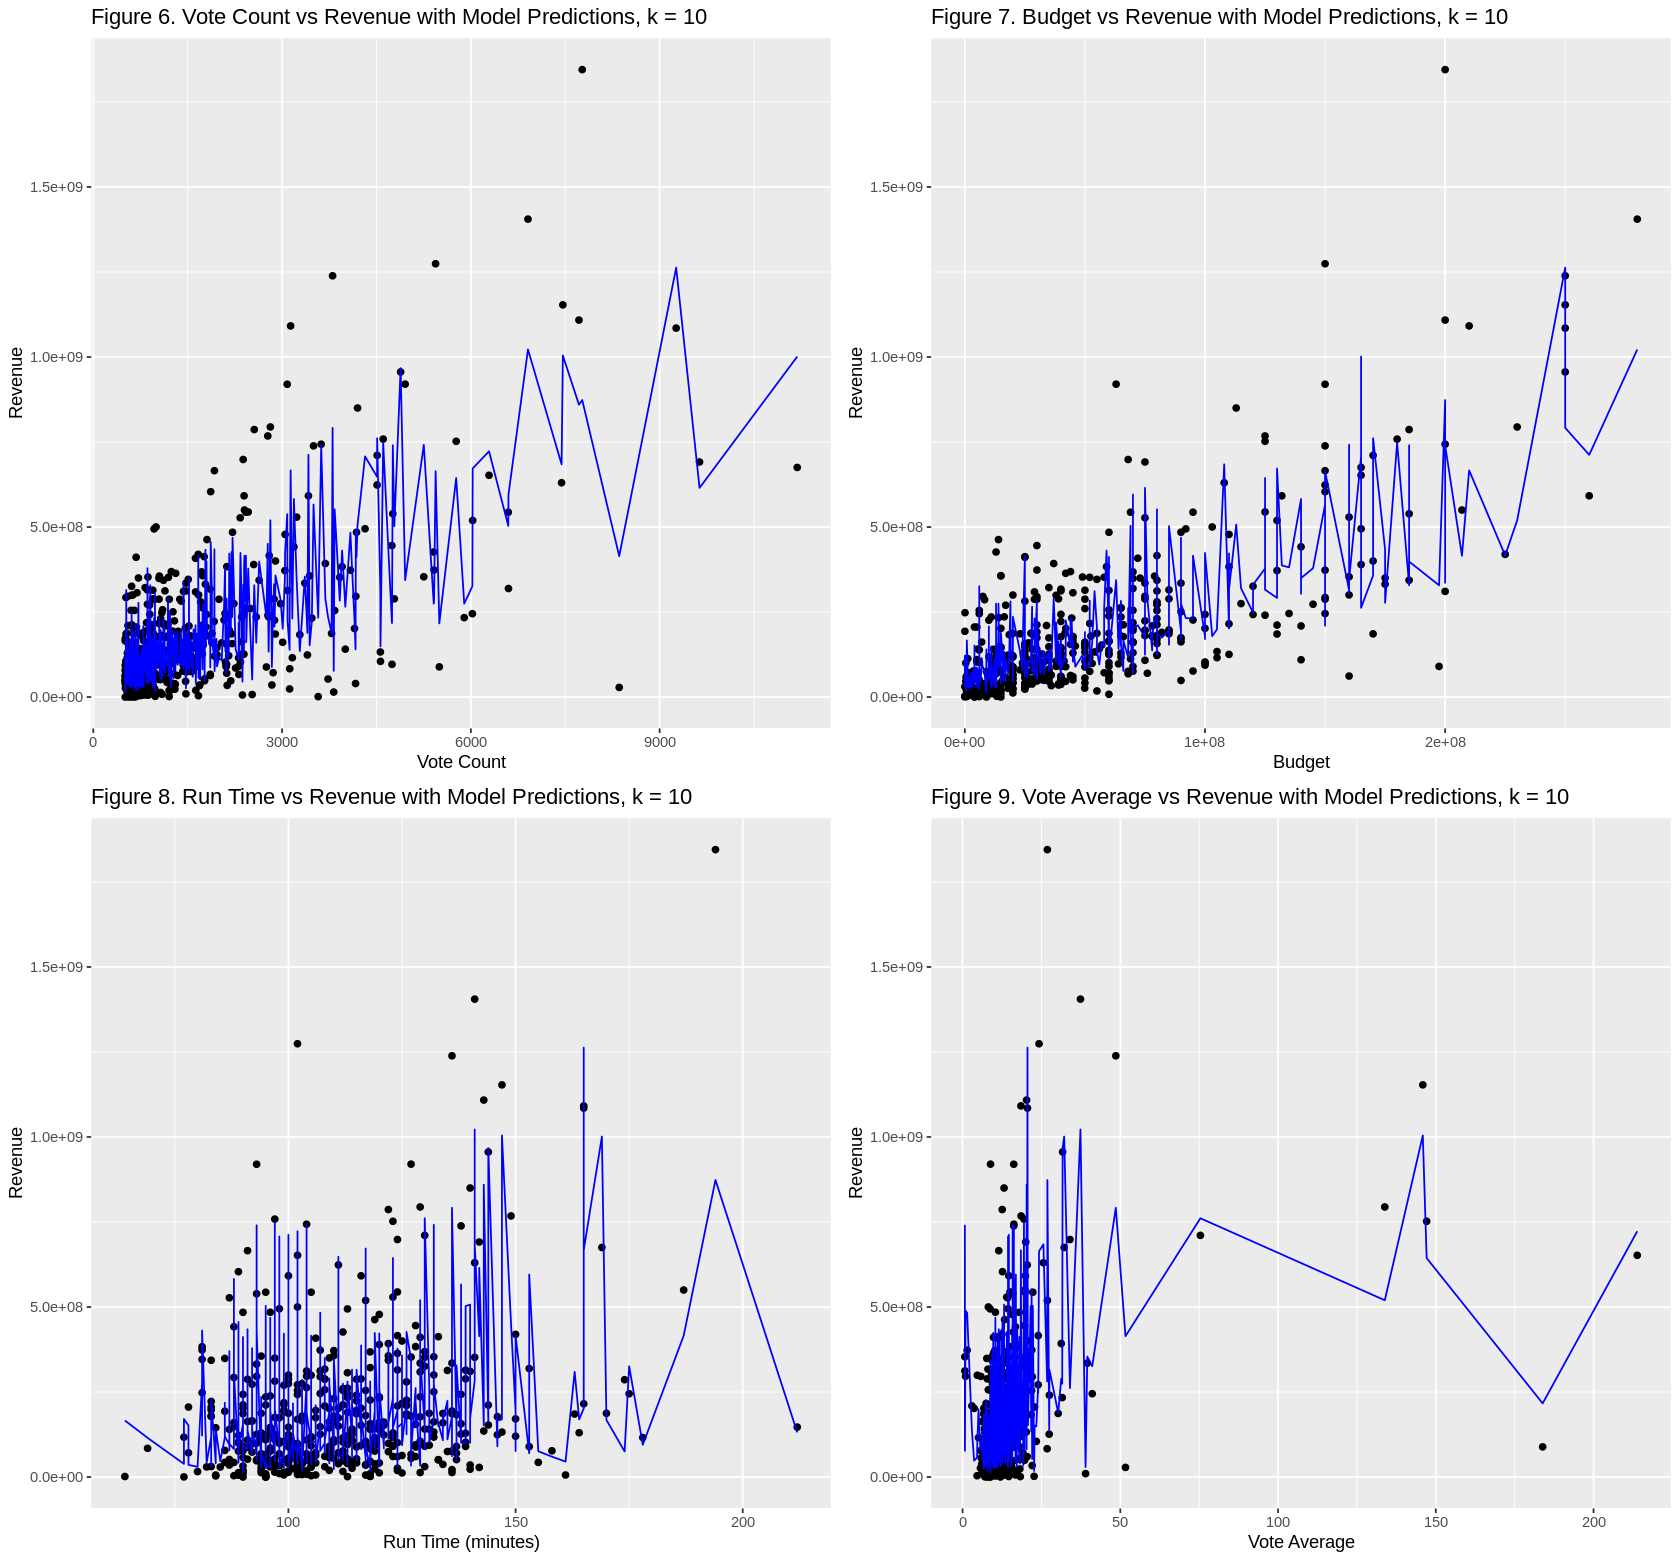

In [19]:
# Generate plots
vote_count_plot <- movie_preds %>%
    ggplot(aes(x = vote_count, y = revenue)) + 
        geom_point() +
        geom_line(data = movie_preds,
                mapping = aes(x = vote_count, y = .pred),
                color = "blue") +
        xlab("Vote Count") + 
        ylab("Revenue") +
        ggtitle("Figure 6. Vote Count vs Revenue with Model Predictions, k = 10")
budget_plot <- movie_preds %>%
    ggplot(aes(x = budget, y = revenue)) + 
        geom_point() +
        geom_line(data = movie_preds,
                mapping = aes(x = budget, y = .pred),
                color = "blue") +
        xlab("Budget") + 
        ylab("Revenue") +
        ggtitle("Figure 7. Budget vs Revenue with Model Predictions, k = 10")
runtime_plot <- movie_preds %>%
    ggplot(aes(x = runtime, y = revenue)) + 
        geom_point() +
        geom_line(data = movie_preds,
                mapping = aes(x = runtime, y = .pred),
                color = "blue") +
        xlab("Run Time (minutes)") + 
        ylab("Revenue") +
        ggtitle("Figure 8. Run Time vs Revenue with Model Predictions, k = 10")
popularity_plot <- movie_preds %>%
    ggplot(aes(x = popularity, y = revenue)) + 
        geom_point() +
        geom_line(data = movie_preds,
                mapping = aes(x = popularity, y = .pred),
                color = "blue") +
        xlab("Vote Average") + 
        ylab("Revenue") +
        ggtitle("Figure 9. Vote Average vs Revenue with Model Predictions, k = 10")

# Display plots
options(repr.plot.width = 14, repr.plot.height = 13)
grid.arrange(vote_count_plot, budget_plot, runtime_plot, popularity_plot, ncol=2)

#### Discussion

##### Predictors

Based on forward selection using knn-regression, we found the following combination of predictors yielded the least error: 
vote_count, budget, runtime, vote_average.
Though it was expected that vote_average, vote_count, and budget would be important predictors, it was unexpected that runtime would be considered by the algorithm to be such an important predictor.

##### RMSPE

The RMSPE was initially considerd to be unexpectedly high. However, upon closer consideration, the value may actually be within normal limits. Considering that the scale of the data is in the billions, small distances from the model prediction will result in large errors in an absolute scale.

Factors that could contribute to elevating the RMSPE include the following:
1. The resulting prediction model produces overfitted results on unseen data. We used k = 14 for the knn algorithm, which is not large enough to be able to construct a smooth prediction line for the test dataset with hundreds of observations. We decided to use this k value because it yielded the lowest RMSE during our model tuning stage over the training dataset.
2. With only 480 movies in the testing dataset, it is possible to be unlucky and obtain a dataset that produces a high RMSPE.

##### Impacts

These findings would be useful for obtaining an estimate of the revenue a movie will generate given: budget, vote count, run time and popularity. Focusing on these key variables may save analysts time in their research in that they will not have to determine which variables to focus on. In addition, the model may have practical uses. The following could be a usage scenario for a data science student:

1. What aspects of a movie should I focus on if I wanted to accurately predict my movie's revenue?
    - vote count, budget, runtime, popularity
2. If I made a movie with a normal data science student budget of $500,000 that had a runtime of 95 minutes and could potentially receive 100 votes and a popularity of 3 on the movies lens website, how much can I revenue can I expect?

In [18]:
new_movie <- tibble(vote_count = 100, budget = 500000, runtime=95, popularity=3)
movie_predicted <- predict(movies_best_fit, new_movie)
movie_predicted

.pred
<dbl>
97398665


Around 62 million dollars! Now what if I took out a loan and made the same movie but with a budget of 5 million dollars?

In [19]:
new_movie_2 <- tibble(vote_count = 100, budget = 5000000, runtime=95, popularity=3)
movie_predicted_2 <- predict(movies_best_fit, new_movie_2)
movie_predicted_2

.pred
<dbl>
107353431


Around 74 million dollars! That is not as much of a gain as I would have hoped; hence, I will not take out the loan and settle with a 500,000 dollars budget.

##### Future Questions

Future questions include:
1. A future study can gather more movie datasets and answer: Are there variables not included in the dataset that could be better predictors?
2. A future study can find and examine more recent data and answer: What effect did the Covid pandemic have on the predictive power of the variables?

#### References

1. Carrillat, F.A., Legoux, R. & Hadida, A.L. Debates and assumptions about motion picture performance: a meta-analysis. J. of the Acad. Mark. Sci. 46, 273–299 (2018). https://doi.org/10.1007/s11747-017-0561-6

2. Gunter, B. (2018). Are the Most Expensive Movies the Most Successful?. In: Predicting Movie Success at the Box Office. Palgrave Macmillan, Cham. https://doi.org/10.1007/978-3-319-71803-3_2